# Working notebook to have a quick look at results

This notebook allows to have a look at the results of a specific calculation. For good plotting, other notebooks are used!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os, sys, gc

import svgutils.transform as sg 

import scipy
from scipy.interpolate import RegularGridInterpolator

import h5py 

import class_energy as energy

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

## Functions for plotting, IO and time propagation

First: a function that allows quick plotting of wavefunctions

In [2]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

Second: a function o get the energies for one symmetry scan

In [3]:
def get_psi_properties(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr

Third: Provided the sum and diff of tunneling rates, return $t_x$ and $t_y$

In [4]:
def get_tx_ty(sum, diff):
    '''  
    Return tx and ty tunneling rates
    '''
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

## Define Calculation Parameters

In [5]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-9}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

### Read the whole folder to see what files are there

In [12]:
sum_tx_ty = 200
diff_tx_ty = 0

B = 2000.0 

Mx = 2
My = 256

tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty)

tx = 0.0
ty = 100.0

params["Mx"] = 2
params["My"] = 256

check_sys = 'tx_150.0_ty_50.0' #'tx_100.5_ty_99.5'
check_sym = '_B_2.0_Mx_128_My_32_qx_0_qy_1' #'_B_10.0_Mx_4_My_32' #_qx_0_qy_0'
file_path = 'results/eff_mass/fdh/' #'results/phase_diagram/fdv/'

h5_io_object = h_in.io_hdf5()
file_list = [f for f in os.listdir(file_path) if check_sys in f and check_sym in f]

V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties(file_path, check_sys, check_sym)

print('files: ', file_list)

print('\nB,tx,ty = ', B, tx, ty)
print('\nV_0: ', V_0_list)
print('\nE: ', E_arr)
print('\nB: ', B_arr)
print('V: ', V_arr)
print('Tx: ', Tx_arr)
print('Ty: ', Ty_arr)

files:  ['tx_150.0_ty_50.0_V0_250_B_2.0_Mx_128_My_32_qx_0_qy_1.hfd5', 'tx_150.0_ty_50.0_V0_100_B_2.0_Mx_128_My_32_qx_0_qy_1.hfd5', 'tx_150.0_ty_50.0_V0_150_B_2.0_Mx_128_My_32_qx_0_qy_1.hfd5', 'tx_150.0_ty_50.0_V0_200_B_2.0_Mx_128_My_32_qx_0_qy_1.hfd5', 'tx_150.0_ty_50.0_V0_50_B_2.0_Mx_128_My_32_qx_0_qy_1.hfd5']

B,tx,ty =  2000.0 0.0 100.0

V_0:  [ 50.+0.j 100.+0.j 150.+0.j 200.+0.j 250.+0.j]

E:  [-380.02565844+6.62328983e-17j -505.20494722-4.45825967e-17j
 -642.48318547+2.06039145e-18j -787.63691498+3.49679206e-17j
 -940.19021798+6.79209059e-18j]

B:  [15.82653479+7.31095259e-17j 23.23660916-4.46122379e-17j
 26.54201621+2.06074661e-18j 27.76289509+3.49676736e-17j
 27.80144609+6.79362575e-18j]
V:  [-115.05031194+0.j -265.00366523+0.j -424.468375  +0.j -594.97774663+0.j
 -783.4546692 +0.j]
Tx:  [-1.87201035-5.63214842e-22j -1.7562526 +2.40383115e-23j
 -1.63037884-2.29014525e-24j -1.46948042+1.65471463e-24j
 -1.23024663-1.25599278e-24j]
Ty:  [-6.57068110e-06-1.35842909e-19j -2.12132500e

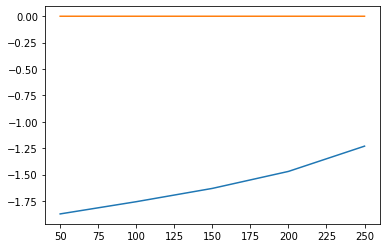

In [13]:
plt.plot(V_0_list, Tx_arr)
plt.plot(V_0_list, Ty_arr)

### Results of one calculation

{'n': 256, 'Mx': 4, 'Mx_display': 4, 'converge_new_lattice': 'no', 'My': 128, 'M': 512, 'My_display': 4, 'B': 2.0, 'tx': 150.0, 'ty': 50.0, 'V_0': 50.0, 'qx': 0, 'qy': 0, 'init_choice': 'ferro_domain_vertical_wall', 'external_wf_tag': ' ', 'excitation_no': 0, 'angle_pattern': [0, 0, 0, 0], 'V_0_pattern': [0, 0, 0, 0], 'n_states': 0, 'path_to_input_wavefunction': ' ', 'dt': 0.001, 'tol': 1e-12}
E = [-202.571112  +1.05486391e-17j  -77.21593862-8.77521090e-28j
   12.39752186+1.05486391e-17j -137.75269525+0.00000000e+00j]
Tx = (-8.996767300911725e-05+5.7777898331617076e-34j)  Ty = (-1.5440488692897647-1.7552155141167513e-29j)
[ 709.37934867  694.10453914  679.49024158 ... -202.57111037 -202.57111119
 -202.571112  ]
[6.54801438e-05 4.92968105e-05 3.77855777e-05 ... 1.00608410e-12
 1.00186526e-12 9.97868455e-13]


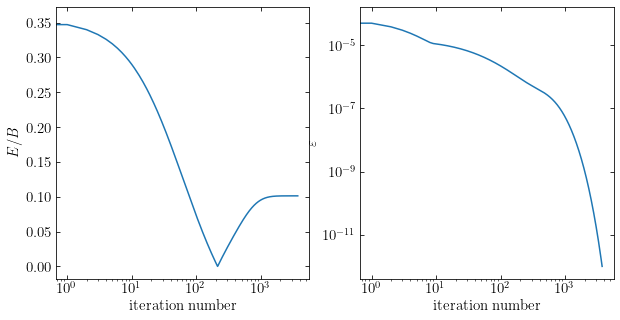

In [101]:
file = file_list[3]
psi, params = h5_io_object.get_psi(file_path+file)
e_evo, epsilon_evo = h5_io_object.get_evo_values(file_path+file)

energy_object = energy.energy(params=params)

E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
Tx, Ty = energy_object.deriv_dE_dt(psi)

print(params)
print('E =', E)
print('Tx =', Tx, ' Ty =', Ty)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, axs = plt.subplots(1,2, figsize=(10,5))

print(e_evo)
print(epsilon_evo)
      
axs[0].plot(np.abs(e_evo)/B)
axs[1].plot(epsilon_evo)

axs[0].set_xscale('log')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].set_xlabel(r'iteration number', fontsize=font_size)
axs[0].set_ylabel(r'$E/B$', fontsize=font_size)

axs[1].set_xlabel(r'iteration number', fontsize=font_size)
axs[1].set_ylabel(r'$\varepsilon$', fontsize=font_size)

axs[0].tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
axs[0].tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

axs[1].tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
axs[1].tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

axs[0].tick_params(which='minor', axis='y', direction='in', right=True)
axs[1].tick_params(which='minor', axis='y', direction='in', right=True)

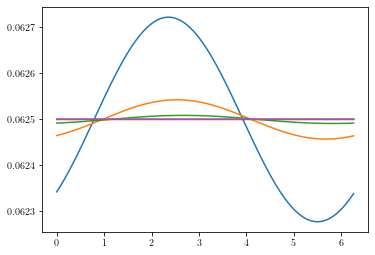

In [86]:

mathieu_parameter = 2*4/200
ye, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x+3*np.pi/4)/2*180/np.pi)
ye = ye/np.sqrt(np.sum(ye*ye))

plt.plot(x,psi[0,0])
plt.plot(x,psi[0,1])
plt.plot(x,psi[0,2])
plt.plot(x,psi[0,5])
plt.plot(x,psi[0,10])
#plt.plot(x,ye)

### Results for scan over many potential points

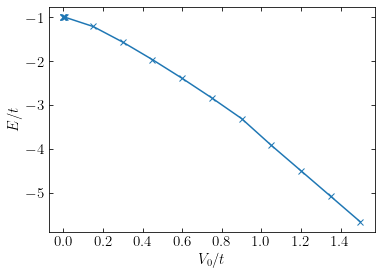

In [172]:
t = 200 

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

plt.plot(V_0_list.real/t, E_arr.real/t, marker='x')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

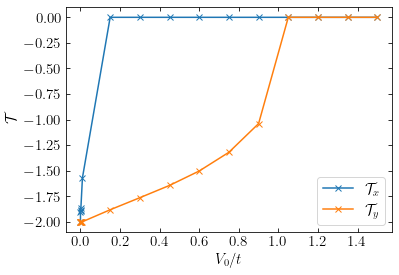

In [173]:
t = 200

plt.plot(V_0_list.real/t, Tx_arr.real, marker='x', label=r'$\mathcal{T}_x$')
plt.plot(V_0_list.real/t, Ty_arr.real, marker='x', label=r'$\mathcal{T}_y$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\mathcal{T}$', fontsize=font_size)

plt.legend(fontsize=font_size) 

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

In [174]:
print('psi shape =', psi.shape)

size_object = mass_size.polaron_size(params=params)
sigma = size_object.calc_polaron_size(psi, '3')

#plot_rotor_wavefunction(x, 10, 2, np.abs(psi.T)**2)

psi shape = (256, 2, 256)


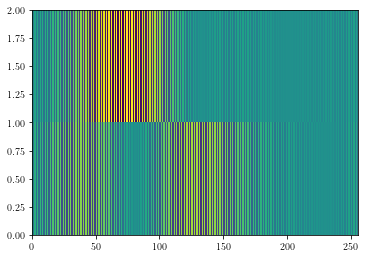

In [175]:
plt.pcolormesh(sigma.T)

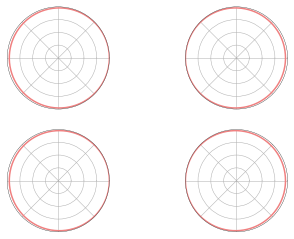

In [146]:
plot_rotor_wavefunction(x, 2, 2, np.abs(psi)**2)

1.0


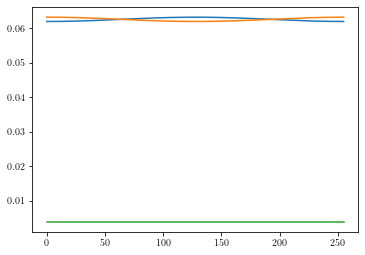

In [149]:
plt.plot(psi[120,0])
plt.plot(psi[120,1])
print(np.sum(np.abs(psi[120,0])**2))
plt.plot(psi[120,0]*psi[120,1])

(1+3.5414028044133963e-20j)


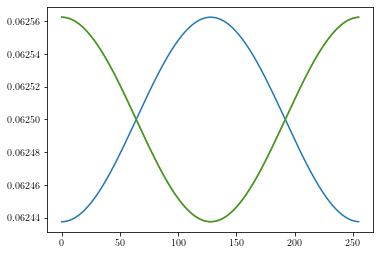

In [176]:
plt.plot(psi[0,0])
plt.plot(psi[0,1])

plt.plot(psi[90,1])

print(np.sum(psi[0,0]*psi[1,0]))

/nfs/scistore12/lemesgrp/fkluiben/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


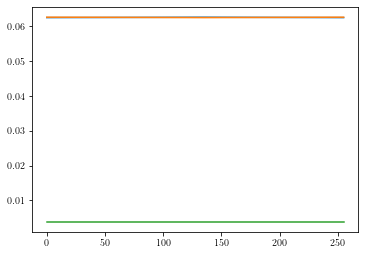

In [177]:
plt.plot(psi[120,0])
plt.plot(psi[120,1])
plt.plot(psi[120,0]*psi[120,1])

(0.1624432754013598+1.8837028838344475e-15j)


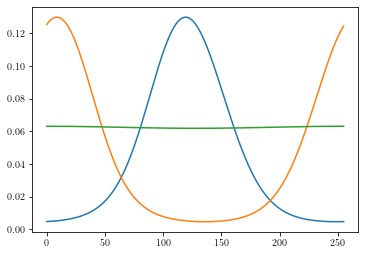

In [123]:
plt.plot(psi[0,0])
plt.plot(psi[0,1])
plt.plot(psi[90,1])

print(np.sum(psi[0,0]*psi[0,1]))

In [122]:
0.16**10

1.0995116277760003e-08

In [139]:
0.999881107460484**1e6

2.304392401401539e-52

In [140]:
0.9999999962135137**1e6

0.9962206733460418

In [157]:

n = 256
k2  = -np.append(np.arange(0,n/2+1),np.arange(-n/2+1,0))**2 # second derivative matrix

single_rotor_deriv_sp = np.einsum('ijk,ijk->ij', np.conjugate(psi), np.fft.ifft(k2*np.fft.fft(psi)))
print(np.sum(single_rotor_deriv_sp)*2)
#sum_elements = np.einsum('ij,ij->ij', single_rotor_deriv_sp, prod_arr)

(-0.05095047769851574-4.604147300142787e-21j)


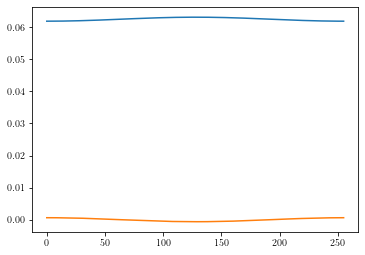

In [165]:
plt.plot(psi[0,0])
plt.plot(np.fft.ifft(k2*np.fft.fft(psi)).real[100,0])

0.00390625